<a href="https://colab.research.google.com/github/massarrahelenna/FoodVision-2025.1/blob/main/Modelo_IA_Jur%C3%ADdica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install Flask requests

In [ ]:
!pip install intel_extension_for_pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 MB 12.2 MB/s eta 0:00:00


In [ ]:
!pip install pandas numpy torch scikit-learn seaborn matplotlib transformers

In [ ]:
!pip install flask-cloudflared

Usando dispositivo: cuda
--- Carregando datasets ---
Dados carregados - Treino/Val: 2081, Teste: 554
Distribuição original das classes:
categoria
NEEDS_LAWYER          946
GENERAL_INFO          606
DOCUMENT_REQUEST      490
NEEDS_LAWYER           20
DOCUMENT_REQUEST       18
NEEDS_LAWYER            1
Name: count, dtype: int64

Distribuição das classes após limpeza:
categoria
NEEDS_LAWYER        967
GENERAL_INFO        606
DOCUMENT_REQUEST    508
Name: count, dtype: int64

--- Pré-processando os dados ---
Pesos de classe calculados automaticamente: tensor([1.3662, 1.1436, 0.7176], device='cuda:0')

--- Preparando DataLoaders ---


tokenizer_config.json:   0%|          | 0.00/43.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/647 [00:00<?, ?B/s]


--- Configurando modelo ---


pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Iniciando treinamento ---

Época 1/10
--------------------------------------------------


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Train loss: 1.0653 | Train acc: 0.4748
Val loss: 0.8339 | Val acc: 0.7626 | Val F1: 0.7312
Modelo salvo: best_model_20251019_180041.pt

Época 2/10
--------------------------------------------------
Train loss: 0.4821 | Train acc: 0.8714
Val loss: 0.2145 | Val acc: 0.9257 | Val F1: 0.9248
Modelo salvo: best_model_20251019_180134.pt

Época 3/10
--------------------------------------------------
Train loss: 0.1727 | Train acc: 0.9321
Val loss: 0.1660 | Val acc: 0.9305 | Val F1: 0.9315
Modelo salvo: best_model_20251019_180218.pt

Época 4/10
--------------------------------------------------
Train loss: 0.1152 | Train acc: 0.9543
Val loss: 0.2016 | Val acc: 0.9257 | Val F1: 0.9249

Época 5/10
--------------------------------------------------
Train loss: 0.0838 | Train acc: 0.9700
Val loss: 0.1642 | Val acc: 0.9472 | Val F1: 0.9470
Modelo salvo: best_model_20251019_180401.pt

Época 6/10
--------------------------------------------------
Train loss: 0.0607 | Train acc: 0.9754
Val loss: 0.179

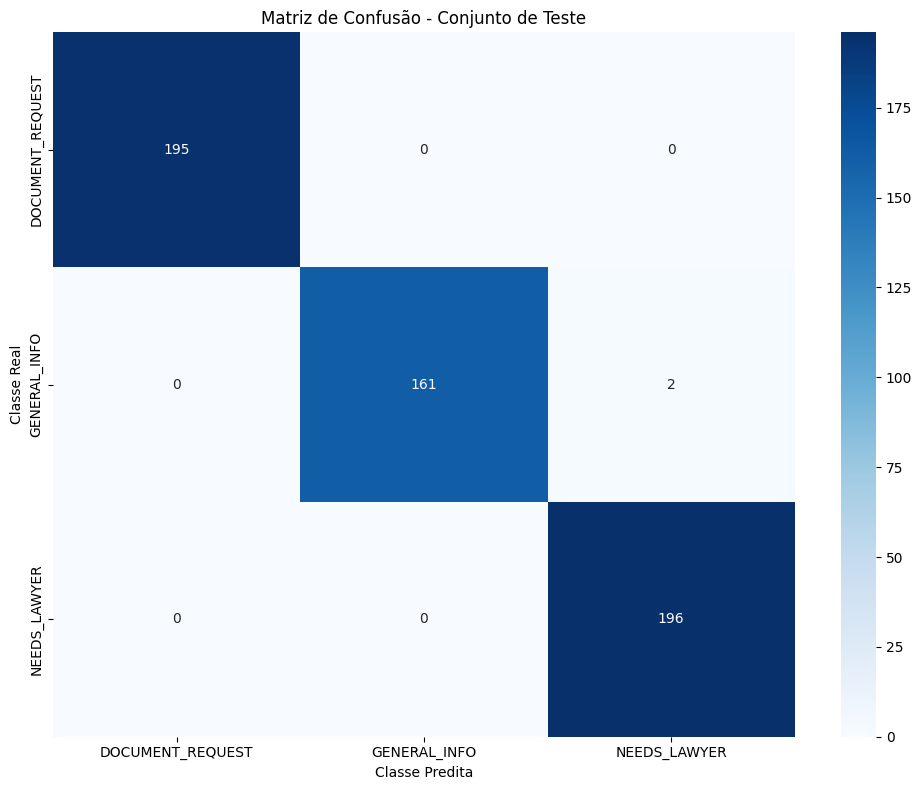

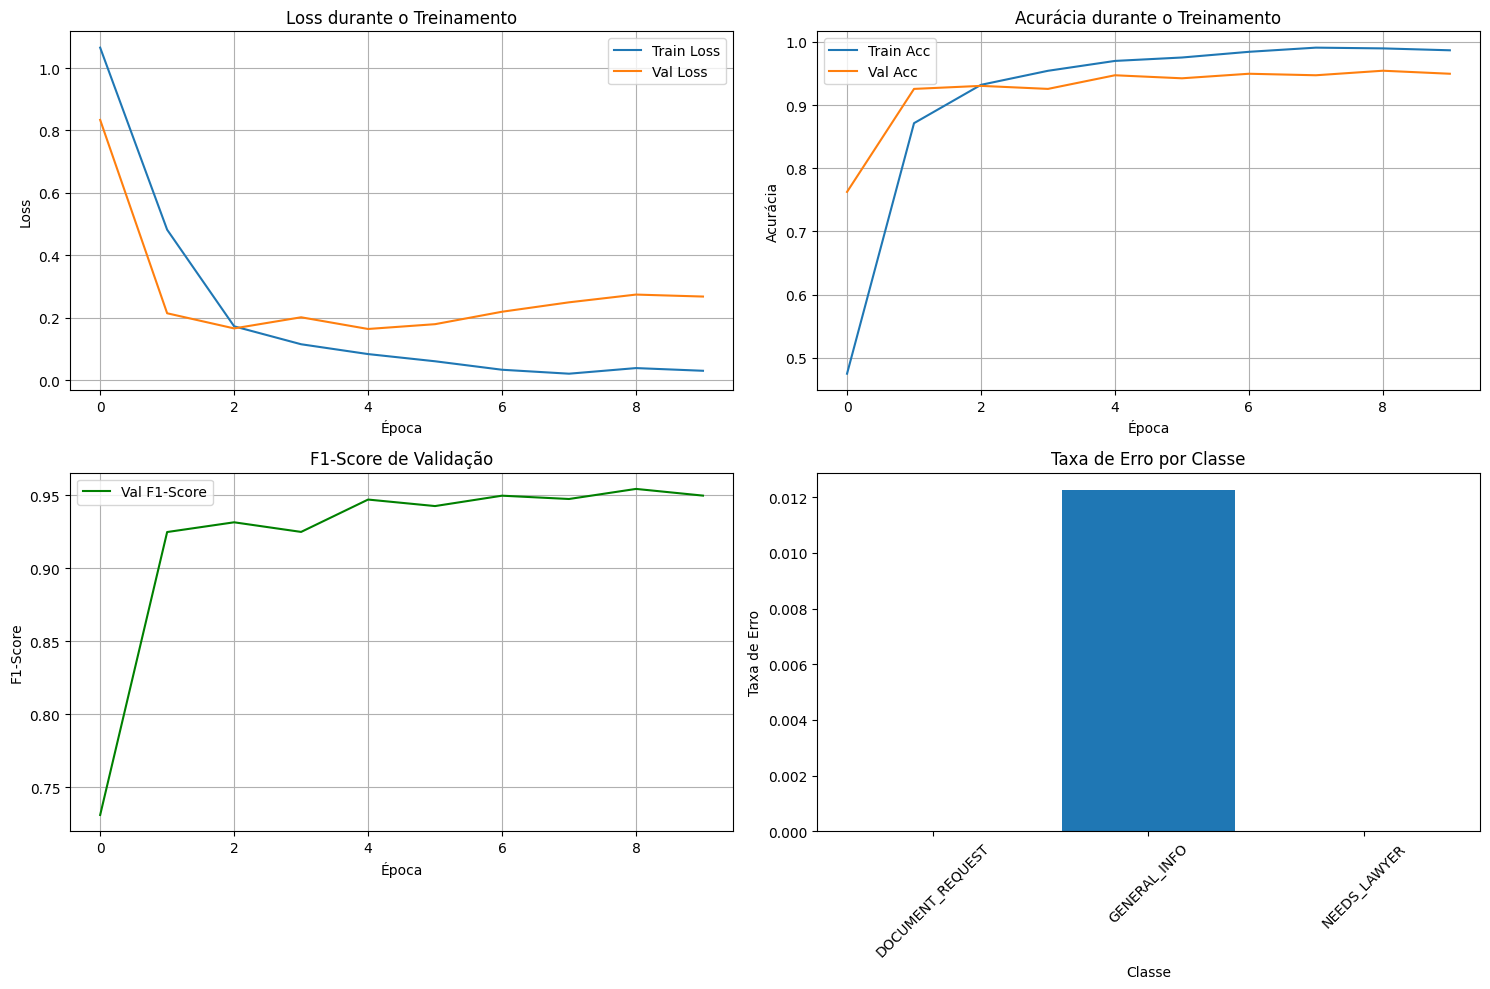


--- Análise Detalhada de Erros ---

Total de erros: 2 (0.36%)

Padrões de erro mais comuns:
categoria_real  categoria_predita
GENERAL_INFO    NEEDS_LAWYER         2
dtype: int64

--- Exemplos de Erros por Padrão ---

GENERAL_INFO → NEEDS_LAWYER (2 casos):
  - quais os meus direitos se a polícia quiser revistar meu carro numa blitz?...
  - se eu for parado numa blitz e não tiver a CNH posso ser preso?...

Resultados salvos em 'resultados_teste_detalhado.csv'

--- Análise de Confiança do Modelo ---

Confiança média por classe:
  DOCUMENT_REQUEST: 1.000
  NEEDS_LAWYER: 0.999
  GENERAL_INFO: 0.997

Previsões com baixa confiança (<0.7): 1 (0.18%)

Exemplos de baixa confiança:
                                             pergunta categoria_real  \
51  se eu for parado numa blitz e não tiver a CNH ...   GENERAL_INFO   

   categoria_predita  confianca  
51      NEEDS_LAWYER   0.560809  

--- Salvando artefatos finais ---

Artefatos salvos em 'model_artifacts/':
  - best_model.pt: Modelo trei

In [ ]:
  # pip install pandas numpy torch scikit-learn seaborn matplotlib transformers
  import pandas as pd
  import numpy as np
  import torch
  import torch.nn as nn
  from sklearn.model_selection import train_test_split
  from sklearn.preprocessing import LabelEncoder
  from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
  from sklearn.utils.class_weight import compute_class_weight
  import seaborn as sns
  import matplotlib.pyplot as plt
  from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup
  from torch.optim import AdamW
  from torch.utils.data import Dataset, DataLoader
  import pickle
  import os
  from datetime import datetime
  import warnings
  warnings.filterwarnings('ignore')

  # CONFIGURAÇÃO DO TREINAMENTO
  NUMERO_DE_EPOCAS = 10  # Aumentado para permitir convergência
  BATCH_SIZE = 16
  LEARNING_RATE = 2e-5  # Ajustado para BERT
  MAX_LEN = 128
  WARMUP_RATIO = 0.1  # 10% dos steps para warmup
  WEIGHT_DECAY = 0.01
  GRADIENT_ACCUMULATION_STEPS = 2  # Para simular batch maior

  # Configuração do dispositivo
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  print(f"Usando dispositivo: {device}")

  # DATASET CUSTOMIZADO PARA MELHOR GESTÃO DE MEMÓRIA
  class TextClassificationDataset(Dataset):
      def __init__(self, texts, labels, tokenizer, max_len):
          self.texts = texts
          self.labels = labels
          self.tokenizer = tokenizer
          self.max_len = max_len

      def __len__(self):
          return len(self.texts)

      def __getitem__(self, idx):
          text = str(self.texts[idx])
          label = self.labels[idx]

          encoding = self.tokenizer.encode_plus(
              text,
              add_special_tokens=True,
              max_length=self.max_len,
              return_token_type_ids=False,
              padding='max_length',
              truncation=True,
              return_attention_mask=True,
              return_tensors='pt',
          )

          return {
              'text': text,
              'input_ids': encoding['input_ids'].flatten(),
              'attention_mask': encoding['attention_mask'].flatten(),
              'label': torch.tensor(label, dtype=torch.long)
          }

  # CARREGAMENTO E PREPARAÇÃO DOS DADOS
  print("--- Carregando datasets ---")

  try:
      df_treino_val = pd.read_csv('dataset_de_treino_oficial.csv')
      df_teste = pd.read_csv('teste_cego_oficial.csv')

      # Verificação básica de qualidade dos dados
      print(f"Dados carregados - Treino/Val: {len(df_treino_val)}, Teste: {len(df_teste)}")
      print(f"Distribuição original das classes:\n{df_treino_val['categoria'].value_counts()}")

      # Limpa espaços em branco do início e fim dos nomes das categorias
      df_treino_val['categoria'] = df_treino_val['categoria'].str.strip()
      df_teste['categoria'] = df_teste['categoria'].str.strip()

      print(f"\nDistribuição das classes após limpeza:\n{df_treino_val['categoria'].value_counts()}")


  except FileNotFoundError:
      print("ERRO: Arquivos não encontrados.")
      raise

  # Divisão estratificada (agora vai funcionar)
  df_treino, df_val = train_test_split(
      df_treino_val,
      test_size=0.2,
      random_state=42,
      stratify=df_treino_val['categoria']
  )

  # PRÉ-PROCESSAMENTO
  print("\n--- Pré-processando os dados ---")

  # Encoding das labels
  label_encoder = LabelEncoder()
  label_encoder.fit(df_treino_val['categoria'])

  # Salvar o encoder para uso futuro
  with open('label_encoder.pkl', 'wb') as f:
      pickle.dump(label_encoder, f)

  # Transformar labels
  y_train = label_encoder.transform(df_treino['categoria'])
  y_val = label_encoder.transform(df_val['categoria'])
  y_test = label_encoder.transform(df_teste['categoria'])

  # Calcular pesos de classe baseados na distribuição real
  class_weights = compute_class_weight(
      'balanced',
      classes=np.unique(y_train),
      y=y_train
  )
  class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
  print(f"Pesos de classe calculados automaticamente: {class_weights}")

  # TOKENIZAÇÃO E DATALOADERS
  print("\n--- Preparando DataLoaders ---")

  tokenizer = BertTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased')

  # Criar datasets
  train_dataset = TextClassificationDataset(
      df_treino['pergunta'].values,
      y_train,
      tokenizer,
      MAX_LEN
  )

  val_dataset = TextClassificationDataset(
      df_val['pergunta'].values,
      y_val,
      tokenizer,
      MAX_LEN
  )

  test_dataset = TextClassificationDataset(
      df_teste['pergunta'].values,
      y_test,
      tokenizer,
      MAX_LEN
  )

  # DataLoaders
  train_loader = DataLoader(
      train_dataset,
      batch_size=BATCH_SIZE,
      shuffle=True,
      num_workers=2 if device.type == 'cuda' else 0
  )

  val_loader = DataLoader(
      val_dataset,
      batch_size=BATCH_SIZE,
      shuffle=False,
      num_workers=2 if device.type == 'cuda' else 0
  )

  test_loader = DataLoader(
      test_dataset,
      batch_size=BATCH_SIZE,
      shuffle=False,
      num_workers=2 if device.type == 'cuda' else 0
  )


  # MODELO E OTIMIZADOR

  print("\n--- Configurando modelo ---")

  model = BertForSequenceClassification.from_pretrained(
      "neuralmind/bert-base-portuguese-cased",  # Usando base ao invés de large
      num_labels=len(label_encoder.classes_),
      output_attentions=False,
      output_hidden_states=False,
      hidden_dropout_prob=0.2,       # Dropout nas camadas "fully connected"
      attention_probs_dropout_prob=0.2   # Dropout nas camadas de atenção
  )
  model.to(device)

  # Otimizador com diferentes learning rates para diferentes camadas
  optimizer_grouped_parameters = [
      {
          'params': [p for n, p in model.named_parameters() if 'bert' in n],
          'lr': LEARNING_RATE
      },
      {
          'params': [p for n, p in model.named_parameters() if 'bert' not in n],
          'lr': LEARNING_RATE * 10  # Maior LR para camada de classificação
      }
  ]

  optimizer = AdamW(optimizer_grouped_parameters, weight_decay=WEIGHT_DECAY)

  # Scheduler
  total_steps = len(train_loader) * NUMERO_DE_EPOCAS
  warmup_steps = int(total_steps * WARMUP_RATIO)

  scheduler = get_linear_schedule_with_warmup(
      optimizer,
      num_warmup_steps=warmup_steps,
      num_training_steps=total_steps
  )

  # Loss function com pesos
  loss_fn = nn.CrossEntropyLoss(weight=class_weights)

  # FUNÇÕES DE TREINAMENTO E VALIDAÇÃO
  def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, accumulation_steps):
      model.train()
      losses = []
      correct_predictions = 0

      for i, batch in enumerate(data_loader):
          input_ids = batch['input_ids'].to(device)
          attention_mask = batch['attention_mask'].to(device)
          labels = batch['label'].to(device)

          outputs = model(
              input_ids=input_ids,
              attention_mask=attention_mask
          )

          loss = loss_fn(outputs.logits, labels)
          loss = loss / accumulation_steps
          losses.append(loss.item() * accumulation_steps)

          _, preds = torch.max(outputs.logits, dim=1)
          correct_predictions += torch.sum(preds == labels)

          loss.backward()

          if (i + 1) % accumulation_steps == 0:
              nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
              optimizer.step()
              scheduler.step()
              optimizer.zero_grad()

      return correct_predictions.double() / len(data_loader.dataset), np.mean(losses)

  def eval_model(model, data_loader, loss_fn, device):
      model.eval()
      losses = []
      correct_predictions = 0
      all_preds = []
      all_labels = []

      with torch.no_grad():
          for batch in data_loader:
              input_ids = batch['input_ids'].to(device)
              attention_mask = batch['attention_mask'].to(device)
              labels = batch['label'].to(device)

              outputs = model(
                  input_ids=input_ids,
                  attention_mask=attention_mask
              )

              loss = loss_fn(outputs.logits, labels)
              losses.append(loss.item())

              _, preds = torch.max(outputs.logits, dim=1)
              correct_predictions += torch.sum(preds == labels)

              all_preds.extend(preds.cpu().numpy())
              all_labels.extend(labels.cpu().numpy())

      accuracy = correct_predictions.double() / len(data_loader.dataset)
      f1 = f1_score(all_labels, all_preds, average='weighted')

      return accuracy, np.mean(losses), f1, all_preds, all_labels

  # TREINAMENTO COM MONITORAMENTO COMPLETO
  print("\n--- Iniciando treinamento ---")

  history = {
      'train_acc': [], 'train_loss': [],
      'val_acc': [], 'val_loss': [], 'val_f1': []
  }

  best_val_f1 = 0
  patience_counter = 0
  patience = 3

  for epoch in range(NUMERO_DE_EPOCAS):
      print(f'\nÉpoca {epoch + 1}/{NUMERO_DE_EPOCAS}')
      print('-' * 50)

      train_acc, train_loss = train_epoch(
          model, train_loader, loss_fn, optimizer,
          device, scheduler, GRADIENT_ACCUMULATION_STEPS
      )

      val_acc, val_loss, val_f1, _, _ = eval_model(
          model, val_loader, loss_fn, device
      )

      print(f'Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f}')
      print(f'Val loss: {val_loss:.4f} | Val acc: {val_acc:.4f} | Val F1: {val_f1:.4f}')

      history['train_acc'].append(train_acc.cpu().numpy())
      history['train_loss'].append(train_loss)
      history['val_acc'].append(val_acc.cpu().numpy())
      history['val_loss'].append(val_loss)
      history['val_f1'].append(val_f1)

      # Early stopping baseado em F1
      if val_f1 > best_val_f1:
          best_val_f1 = val_f1
          patience_counter = 0

          # Salvar melhor modelo com timestamp
          timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
          model_path = f'best_model_{timestamp}.pt'
          torch.save({
              'epoch': epoch,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'val_f1': val_f1,
              'val_acc': val_acc,
          }, model_path)
          print(f'Modelo salvo: {model_path}')

          # Link simbólico para o melhor modelo
          if os.path.exists('best_model.pt'):
              os.remove('best_model.pt')
          os.symlink(model_path, 'best_model.pt')

      else:
          patience_counter += 1
          if patience_counter >= patience:
              print(f'Early stopping triggered after {epoch + 1} epochs')
              break

  # AVALIAÇÃO FINAL E ANÁLISE
  print("\n--- Avaliação final no conjunto de teste ---")

  # Carregar melhor modelo
  checkpoint = torch.load('best_model.pt')
  model.load_state_dict(checkpoint['model_state_dict'])

  test_acc, test_loss, test_f1, test_preds, test_labels = eval_model(
      model, test_loader, loss_fn, device
  )

  print(f"\nResultados no conjunto de teste:")
  print(f"Acurácia: {test_acc:.4f}")
  print(f"F1-Score: {test_f1:.4f}")
  print(f"Loss: {test_loss:.4f}")

  # Relatório detalhado
  print("\nRelatório de Classificação:")
  print(classification_report(
      test_labels,
      test_preds,
      target_names=label_encoder.classes_
  ))

  # VISUALIZAÇÕES
  # 1. Matriz de Confusão
  plt.figure(figsize=(10, 8))
  cm = confusion_matrix(test_labels, test_preds)
  sns.heatmap(
      cm,
      annot=True,
      fmt='d',
      cmap='Blues',
      xticklabels=label_encoder.classes_,
      yticklabels=label_encoder.classes_
  )
  plt.title('Matriz de Confusão - Conjunto de Teste')
  plt.ylabel('Classe Real')
  plt.xlabel('Classe Predita')
  plt.tight_layout()
  plt.savefig('confusion_matrix.png', dpi=300)
  plt.show()

  # 2. Histórico de Treinamento
  fig, axes = plt.subplots(2, 2, figsize=(15, 10))

  # Loss
  axes[0, 0].plot(history['train_loss'], label='Train Loss')
  axes[0, 0].plot(history['val_loss'], label='Val Loss')
  axes[0, 0].set_title('Loss durante o Treinamento')
  axes[0, 0].set_xlabel('Época')
  axes[0, 0].set_ylabel('Loss')
  axes[0, 0].legend()
  axes[0, 0].grid(True)

  # Acurácia
  axes[0, 1].plot(history['train_acc'], label='Train Acc')
  axes[0, 1].plot(history['val_acc'], label='Val Acc')
  axes[0, 1].set_title('Acurácia durante o Treinamento')
  axes[0, 1].set_xlabel('Época')
  axes[0, 1].set_ylabel('Acurácia')
  axes[0, 1].legend()
  axes[0, 1].grid(True)

  # F1-Score
  axes[1, 0].plot(history['val_f1'], label='Val F1-Score', color='green')
  axes[1, 0].set_title('F1-Score de Validação')
  axes[1, 0].set_xlabel('Época')
  axes[1, 0].set_ylabel('F1-Score')
  axes[1, 0].legend()
  axes[1, 0].grid(True)

  # Distribuição de Erros por Classe
  errors_by_class = []
  for i, class_name in enumerate(label_encoder.classes_):
      class_mask = np.array(test_labels) == i
      class_errors = np.sum((np.array(test_preds) != np.array(test_labels)) & class_mask)
      class_total = np.sum(class_mask)
      error_rate = class_errors / class_total if class_total > 0 else 0
      errors_by_class.append(error_rate)

  axes[1, 1].bar(label_encoder.classes_, errors_by_class)
  axes[1, 1].set_title('Taxa de Erro por Classe')
  axes[1, 1].set_xlabel('Classe')
  axes[1, 1].set_ylabel('Taxa de Erro')
  axes[1, 1].tick_params(axis='x', rotation=45)

  plt.tight_layout()
  plt.savefig('training_history.png', dpi=300)
  plt.show()

  # ANÁLISE DETALHADA DE ERROS
  print("\n--- Análise Detalhada de Erros ---")

  # Reconstruir previsões e labels com textos originais
  test_texts = []
  test_true_labels = []
  test_pred_labels = []

  model.eval()
  with torch.no_grad():
      for batch in test_loader:
          texts = batch['text']
          labels = batch['label']

          input_ids = batch['input_ids'].to(device)
          attention_mask = batch['attention_mask'].to(device)

          outputs = model(input_ids=input_ids, attention_mask=attention_mask)
          _, preds = torch.max(outputs.logits, dim=1)

          test_texts.extend(texts)
          test_true_labels.extend(labels.numpy())
          test_pred_labels.extend(preds.cpu().numpy())

  # Criar DataFrame com resultados
  results_df = pd.DataFrame({
      'pergunta': test_texts,
      'categoria_real': label_encoder.inverse_transform(test_true_labels),
      'categoria_predita': label_encoder.inverse_transform(test_pred_labels),
      'correto': np.array(test_true_labels) == np.array(test_pred_labels)
  })

  # Filtrar erros
  erros_df = results_df[~results_df['correto']]

  if len(erros_df) > 0:
      print(f"\nTotal de erros: {len(erros_df)} ({len(erros_df)/len(results_df)*100:.2f}%)")

      # Análise de padrões de erro
      print("\nPadrões de erro mais comuns:")
      error_patterns = erros_df.groupby(['categoria_real', 'categoria_predita']).size().sort_values(ascending=False)
      print(error_patterns.head(10))

      # Exemplos de erros por padrão
      print("\n--- Exemplos de Erros por Padrão ---")
      for (real, pred), count in error_patterns.head(3).items():
          print(f"\n{real} → {pred} ({count} casos):")
          exemplos = erros_df[(erros_df['categoria_real'] == real) &
                            (erros_df['categoria_predita'] == pred)].head(2)
          for _, row in exemplos.iterrows():
              print(f"  - {row['pergunta'][:100]}...")
  else:
      print("\nNenhum erro encontrado no conjunto de teste!")

  # Salvar resultados detalhados
  results_df.to_csv('resultados_teste_detalhado.csv', index=False)
  print("\nResultados salvos em 'resultados_teste_detalhado.csv'")

  def predict_batch(texts, model, tokenizer, label_encoder, device, batch_size=32):
      """
      Função otimizada para fazer previsões em lote
      """
      model.eval()
      predictions = []
      probabilities = []

      # Processar em lotes
      for i in range(0, len(texts), batch_size):
          batch_texts = texts[i:i+batch_size]

          # Tokenizar
          encodings = tokenizer(
              batch_texts,
              truncation=True,
              padding=True,
              max_length=MAX_LEN,
              return_tensors='pt'
          )

          input_ids = encodings['input_ids'].to(device)
          attention_mask = encodings['attention_mask'].to(device)

          # Fazer previsão
          with torch.no_grad():
              outputs = model(input_ids=input_ids, attention_mask=attention_mask)
              probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
              preds = torch.argmax(outputs.logits, dim=-1)

              predictions.extend(preds.cpu().numpy())
              probabilities.extend(probs.cpu().numpy())

      # Converter para labels
      predicted_labels = label_encoder.inverse_transform(predictions)

      return predicted_labels, np.array(probabilities)

  # ANÁLISE DE CONFIANÇA DO MODELO
  print("\n--- Análise de Confiança do Modelo ---")

  # Calcular probabilidades para o conjunto de teste
  _, test_probabilities = predict_batch(
      df_teste['pergunta'].tolist(),
      model, tokenizer, label_encoder, device
  )

  # Confiança média por classe
  max_probs = np.max(test_probabilities, axis=1)
  confidence_by_class = {}

  for i, class_name in enumerate(label_encoder.classes_):
      class_mask = np.array(test_true_labels) == i
      if np.sum(class_mask) > 0:
          class_confidence = max_probs[class_mask].mean()
          confidence_by_class[class_name] = class_confidence

  print("\nConfiança média por classe:")
  for class_name, conf in sorted(confidence_by_class.items(), key=lambda x: x[1], reverse=True):
      print(f"  {class_name}: {conf:.3f}")

  # Identificar previsões de baixa confiança
  low_confidence_threshold = 0.7
  low_confidence_mask = max_probs < low_confidence_threshold
  low_confidence_count = np.sum(low_confidence_mask)

  print(f"\nPrevisões com baixa confiança (<{low_confidence_threshold}): {low_confidence_count} ({low_confidence_count/len(max_probs)*100:.2f}%)")

  if low_confidence_count > 0:
      low_conf_df = results_df[low_confidence_mask].copy()
      low_conf_df['confianca'] = max_probs[low_confidence_mask]
      print("\nExemplos de baixa confiança:")
      print(low_conf_df[['pergunta', 'categoria_real', 'categoria_predita', 'confianca']].head())

  print("\n--- Salvando artefatos finais ---")

  # Criar diretório para artefatos
  os.makedirs('model_artifacts', exist_ok=True)

  # Salvar configuração do modelo
  config = {
      'model_name': 'neuralmind/bert-base-portuguese-cased',
      'num_labels': len(label_encoder.classes_),
      'max_length': MAX_LEN,
      'batch_size': BATCH_SIZE,
      'learning_rate': LEARNING_RATE,
      'num_epochs': epoch + 1,  # Épocas realmente treinadas
      'best_val_f1': float(best_val_f1),
      'test_accuracy': float(test_acc),
      'test_f1': float(test_f1),
      'label_mapping': dict(enumerate(label_encoder.classes_))
  }

  with open('model_artifacts/config.json', 'w') as f:
      import json
      json.dump(config, f, indent=2)

  # Mover arquivos importantes
  import shutil
  shutil.move('label_encoder.pkl', 'model_artifacts/label_encoder.pkl')
  shutil.copy('best_model.pt', 'model_artifacts/best_model.pt')

  print("\nArtefatos salvos em 'model_artifacts/':")
  print("  - best_model.pt: Modelo treinado")
  print("  - label_encoder.pkl: Encoder de labels")
  print("  - config.json: Configuração do modelo")

  # SCRIPT DE INFERÊNCIA PARA PRODUÇÃO
  inference_script = '''
  import torch
  import pickle
  import json
  from transformers import BertTokenizer, BertForSequenceClassification

  class TextClassifier:
      def __init__(self, artifacts_path='model_artifacts'):
          # Carregar configuração
          with open(f'{artifacts_path}/config.json', 'r') as f:
              self.config = json.load(f)

          # Carregar label encoder
          with open(f'{artifacts_path}/label_encoder.pkl', 'rb') as f:
              self.label_encoder = pickle.load(f)

          # Carregar tokenizer
          self.tokenizer = BertTokenizer.from_pretrained(self.config['model_name'])

          # Carregar modelo
          self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
          self.model = BertForSequenceClassification.from_pretrained(
              self.config['model_name'],
              num_labels=self.config['num_labels']
          )

          checkpoint = torch.load(f'{artifacts_path}/best_model.pt', map_location=self.device)
          self.model.load_state_dict(checkpoint['model_state_dict'])
          self.model.to(self.device)
          self.model.eval()

      def predict(self, text):
          # Tokenizar
          inputs = self.tokenizer(
              text,
              return_tensors='pt',
              truncation=True,
              padding=True,
              max_length=self.config['max_length']
          )

          # Mover para dispositivo
          inputs = {k: v.to(self.device) for k, v in inputs.items()}

          # Fazer previsão
          with torch.no_grad():
              outputs = self.model(**inputs)
              probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)
              prediction = torch.argmax(outputs.logits, dim=-1)

          # Converter para label
          label = self.label_encoder.inverse_transform([prediction.cpu().numpy()[0]])[0]
          confidence = probabilities.max().item()

          # Todas as probabilidades
          all_probs = {}
          for i, prob in enumerate(probabilities[0].cpu().numpy()):
              class_name = self.label_encoder.inverse_transform([i])[0]
              all_probs[class_name] = float(prob)

          return {
              'prediction': label,
              'confidence': confidence,
              'probabilities': all_probs
          }

  # Exemplo de uso:
  if __name__ == '__main__':
      classifier = TextClassifier()

      # Testar com uma pergunta
      result = classifier.predict("Preciso de um advogado para resolver meu caso?")
      print(f"Predição: {result['prediction']}")
      print(f"Confiança: {result['confidence']:.3f}")
      print(f"Probabilidades: {result['probabilities']}")
  '''

  with open('inference.py', 'w') as f:
      f.write(inference_script)

  print("\nScript de inferência salvo como 'inference.py'")
  print("\n=== TREINAMENTO CONCLUÍDO COM SUCESSO ===")

In [ ]:
# Teste download
from huggingface_hub import hf_hub_download

try:
    # Tentar baixar um arquivo do dataset
    path = hf_hub_download(
        repo_id="thalissonol/model-bert-sprint-idp",
        filename="best_model.pt",
        repo_type="dataset"
    )
    print(f"Arquivo baixado com sucesso: {path}")
except Exception as e:
    print(f"Erro: {e}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


best_model.pt:   0%|          | 0.00/436M [00:00<?, ?B/s]

✅ Arquivo baixado com sucesso: /root/.cache/huggingface/hub/datasets--thalissonol--model-bert-sprint-idp/snapshots/bf16c473d51966d1bd2faa44dffb0cd691346926/best_model.pt


In [ ]:
import torch
import os
import json
import shutil
from transformers import BertForSequenceClassification

# =================================================================
# CONFIGURAÇÃO DOS CAMINHOS
# =================================================================
# De onde vamos ler o modelo treinado
INPUT_ARTIFACTS_PATH = 'model_artifacts'
# Para onde vamos salvar a versão comprimida
OUTPUT_ARTIFACTS_PATH = 'model_artifacts_compressed'


# =================================================================
# FUNÇÃO PRINCIPAL DE COMPRESSÃO
# =================================================================
def compress_model_artifacts():
    """
    Carrega os artefatos de um modelo treinado, comprime o arquivo de pesos
    para float16 e salva em um novo diretório pronto para produção.
    """
    print(f"--- Iniciando compressão de '{INPUT_ARTIFACTS_PATH}' para '{OUTPUT_ARTIFACTS_PATH}' ---")

    # 1. Verificar se os arquivos de entrada existem
    model_file = os.path.join(INPUT_ARTIFACTS_PATH, 'best_model.pt')
    config_file = os.path.join(INPUT_ARTIFACTS_PATH, 'config.json')
    encoder_file = os.path.join(INPUT_ARTIFACTS_PATH, 'label_encoder.pkl')

    if not all(os.path.exists(f) for f in [model_file, config_file, encoder_file]):
        print(f"Erro: Um ou mais arquivos não encontrados no diretório '{INPUT_ARTIFACTS_PATH}'.")
        print("Certifique-se de que o treinamento foi concluído com sucesso.")
        return

    # 2. Criar o diretório de saída
    os.makedirs(OUTPUT_ARTIFACTS_PATH, exist_ok=True)
    print(f"Diretório de saída '{OUTPUT_ARTIFACTS_PATH}' criado/verificado.")

    try:
        # 3. Carregar a configuração
        with open(config_file, 'r') as f:
            config = json.load(f)
        print("Configuração (config.json) carregada.")

        # 4. Carregar a estrutura do modelo base (sem os pesos treinados)
        model = BertForSequenceClassification.from_pretrained(
            config['model_name'],
            num_labels=config['num_labels']
        )
        print(f"Estrutura do modelo '{config['model_name']}' carregada.")

        # 5. Carregar o checkpoint treinado (a "caixa")
        checkpoint = torch.load(model_file, map_location='cpu')
        print("Checkpoint (best_model.pt) carregado.")

        # 6. Carregar os pesos treinados na estrutura do modelo (abrindo a "caixa")
        if 'model_state_dict' in checkpoint:
            model.load_state_dict(checkpoint['model_state_dict'])
            print("Pesos do 'model_state_dict' aplicados ao modelo.")
        else:
            # Caso o .pt contenha apenas os pesos
            model.load_state_dict(checkpoint)
            print("Pesos do arquivo aplicados diretamente ao modelo.")

        # 7. A MÁGICA DA COMPRESSÃO: Converter o modelo para float16 (meia precisão)
        model.half()
        print("Modelo convertido para float16 (meia precisão) para compressão.")

        # 8. Salvar o novo state_dict (apenas os pesos), que agora é muito menor
        output_model_file = os.path.join(OUTPUT_ARTIFACTS_PATH, 'best_model.pt')
        # Nós salvamos um checkpoint COMPLETO, para manter a compatibilidade com o código da API
        torch.save({'model_state_dict': model.state_dict()}, output_model_file)

        # 9. Copiar os outros arquivos essenciais
        shutil.copy(config_file, os.path.join(OUTPUT_ARTIFACTS_PATH, 'config.json'))
        shutil.copy(encoder_file, os.path.join(OUTPUT_ARTIFACTS_PATH, 'label_encoder.pkl'))
        print("config.json e label_encoder.pkl copiados para o diretório de saída.")

        # 10. Comparar os tamanhos
        original_size = os.path.getsize(model_file) / (1024 * 1024)
        compressed_size = os.path.getsize(output_model_file) / (1024 * 1024)
        reduction = ((original_size - compressed_size) / original_size) * 100 if original_size > 0 else 0

        print("\n--- COMPRESSÃO CONCLUÍDA ---")
        print(f"Tamanho Original do Modelo: {original_size:.2f} MB")
        print(f"Tamanho Comprimido do Modelo: {compressed_size:.2f} MB")
        print(f"Redução de tamanho: {reduction:.1f}%")
        print(f"\nArtefatos otimizados e prontos para produção estão em: '{OUTPUT_ARTIFACTS_PATH}'")

    except Exception as e:
        print(f"\nOcorreu um erro durante o processo de compressão: {e}")

# EXECUTAR O SCRIPT
if __name__ == "__main__":
    compress_model_artifacts()


--- Iniciando compressão de 'model_artifacts' para 'model_artifacts_compressed' ---
Diretório de saída 'model_artifacts_compressed' criado/verificado.
✅ Configuração (config.json) carregada.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Estrutura do modelo 'neuralmind/bert-base-portuguese-cased' carregada.
✅ Checkpoint (best_model.pt) carregado.
✅ Pesos do 'model_state_dict' aplicados ao modelo.
⚡️ Modelo convertido para float16 (meia precisão) para compressão.
✅ config.json e label_encoder.pkl copiados para o diretório de saída.

--- ✅ COMPRESSÃO CONCLUÍDA ---
Tamanho Original do Modelo: 1246.81 MB
Tamanho Comprimido do Modelo: 207.83 MB
Redução de tamanho: 83.3%

Artefatos otimizados e prontos para produção estão em: 'model_artifacts_compressed'


In [ ]:
from flask import Flask, request, jsonify
import torch
import pickle
import json
from transformers import BertTokenizer, BertForSequenceClassification
import logging
import os
from huggingface_hub import hf_hub_download, snapshot_download, login
import numpy as np

# Configurar logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

app = Flask(__name__)

# ATENÇÃO: Este é um DATASET repository, não model repository
DATASET_REPO = "thalissonol/model-bert-sprint-idp"
REPO_TYPE = "dataset"  # Especificar que é um dataset

TYPE_FILE = 'best_model_ulta_leve.pt'  # 'best_model.pt', 'best_model_state_dict_otimizado.pt', 'best_model_complete.pt', 'best_model_ulta_leve.pt',

def setup_huggingface_auth():
    """Configura autenticação do Hugging Face se disponível"""
    hf_token = os.environ.get('HUGGINGFACE_HUB_TOKEN')
    if hf_token:
        login(token=hf_token)
        return True
    return False

def download_from_dataset():
    """Baixa arquivos de um dataset do Hugging Face"""
    try:
        logger.info("Baixando arquivos do dataset...")

        # Lista de arquivos que precisamos baixar
        required_files = {
            'model': TYPE_FILE,
            'label_encoder': 'label_encoder.pkl',
            'config': 'config.json'
        }

        artifacts = {}

        for key, filename in required_files.items():
            try:
                file_path = hf_hub_download(
                    repo_id=DATASET_REPO,
                    filename=filename,
                    repo_type=REPO_TYPE,
                    force_download=True
                )
                artifacts[key] = file_path
                logger.info(f" {filename} baixado com sucesso")

            except Exception as e:
                logger.error(f" Erro ao baixar {filename}: {str(e)}")
                raise

        return artifacts

    except Exception as e:
        logger.warning(f"Erro ao baixar do dataset: {str(e)}")
        raise

def download_dataset_alternative():
    """Alternativa: baixa todo o dataset"""
    try:
        cache_dir = snapshot_download(
            repo_id=DATASET_REPO,
            repo_type=REPO_TYPE,
            force_download=True
        )
        logger.info(f"Dataset baixado para: {cache_dir}")
        return cache_dir
    except Exception as e:
        logger.warning(f"Erro ao baixar dataset completo: {str(e)}")
        raise

def load_local_artifacts():
    """Tenta carregar de arquivos locais ou do cache - CORRIGIDO: removido self"""
    try:
        logger.info("Tentando carregar de arquivos locais ou cache...")

        # Primeiro tenta o diretório local
        local_path = "model_artifacts"
        if os.path.exists(local_path):
            artifacts = {
                'model': os.path.join(local_path, TYPE_FILE),
                'label_encoder': os.path.join(local_path, 'label_encoder.pkl'),
                'config': os.path.join(local_path, 'config.json')
            }
        else:
            # Tenta encontrar nos arquivos baixados do Hugging Face
            cache_dir = os.path.expanduser("~/.cache/huggingface/hub")
            # Procura recursivamente pelos arquivos
            artifacts = {}
            for root, dirs, files in os.walk(cache_dir):
                for file in files:
                    if file == TYPE_FILE:
                        artifacts['model'] = os.path.join(root, file)
                    elif file == 'label_encoder.pkl':
                        artifacts['label_encoder'] = os.path.join(root, file)
                    elif file == 'config.json':
                        artifacts['config'] = os.path.join(root, file)

            if len(artifacts) != 3:
                raise FileNotFoundError("Não foi possível encontrar todos os arquivos do modelo")

        # Verificar se todos os arquivos existem
        for key, path in artifacts.items():
            if not os.path.exists(path):
                raise FileNotFoundError(f"Arquivo {path} não encontrado")
            else:
                logger.info(f" Arquivo encontrado: {path}")

        return artifacts

    except Exception as e:
        logger.warning(f" Falha ao carregar localmente: {str(e)}")
        raise

class TextClassifier:
    def __init__(self):
        self.model_loaded = False
        self.load_source = "none"

        # Tentar carregar do Dataset Hub primeiro
        if self._try_load_from_dataset():
            self.model_loaded = True
            self.load_source = "huggingface_dataset"
        # Fallback para arquivos locais
        elif self._try_load_local():
            self.model_loaded = True
            self.load_source = "local"
        else:
            raise Exception("Não foi possível carregar o modelo de nenhuma fonte")

    def _try_load_from_dataset(self):
        """Tenta carregar do Hugging Face Dataset"""
        try:
            logger.info("Tentando carregar do Hugging Face Dataset...")

            # Configurar autenticação se disponível
            setup_huggingface_auth()

            # Tentar método principal primeiro
            try:
                artifacts = download_from_dataset()
            except Exception as e:
                logger.warning(f"Método principal falhou: {str(e)}")
                # Tentar método alternativo
                cache_dir = download_dataset_alternative()
                artifacts = {
                    'model': os.path.join(cache_dir, TYPE_FILE),
                    'label_encoder': os.path.join(cache_dir, 'label_encoder.pkl'),
                    'config': os.path.join(cache_dir, 'config.json')
                }

            self._load_from_artifacts(artifacts)
            logger.info(" Modelo carregado com sucesso do Hugging Face Dataset!")
            return True

        except Exception as e:
            logger.warning(f" Falha ao carregar do Dataset: {str(e)}")
            return False

    def _try_load_local(self):
        """Tenta carregar de arquivos locais"""
        try:
            logger.info("Tentando carregar de arquivos locais...")
            artifacts = load_local_artifacts()  # CORRIGIDO: sem self
            self._load_from_artifacts(artifacts)
            logger.info(" Modelo carregado com sucesso de arquivos locais!")
            return True
        except Exception as e:
            logger.warning(f" Falha ao carregar localmente: {str(e)}")
            return False

    def _load_from_artifacts(self, artifacts):
        """Carrega modelo a partir dos artefatos - CORRIGIDO para lidar com pesos parciais"""
        try:
            # Carregar configuração
            with open(artifacts['config'], 'r', encoding='utf-8') as f:
                self.config = json.load(f)

            # Carregar label encoder com tratamento de warning
            import warnings
            with warnings.catch_warnings():
                warnings.filterwarnings("ignore", category=UserWarning)
                with open(artifacts['label_encoder'], 'rb') as f:
                    self.label_encoder = pickle.load(f)

            # Carregar tokenizer
            self.tokenizer = BertTokenizer.from_pretrained(self.config['model_name'])

            # Carregar modelo
            self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
            logger.info(f"Usando dispositivo: {self.device}")

            self.model = BertForSequenceClassification.from_pretrained(
                self.config['model_name'],
                num_labels=self.config['num_labels']
            )

            # Carregar os pesos treinados - COM TRATAMENTO PARA PESOS PARCIAIS
            checkpoint = torch.load(artifacts['model'], map_location=self.device)

            # Verificar a estrutura do checkpoint e carregar apropriadamente
            if 'model_state_dict' in checkpoint:
                state_dict = checkpoint['model_state_dict']
            else:
                state_dict = checkpoint

            # Verificar se temos pesos completos ou apenas do classificador
            model_state_dict = self.model.state_dict()

            # Filtrar apenas as chaves que existem no modelo e no checkpoint
            filtered_state_dict = {}
            for k, v in state_dict.items():
                if k in model_state_dict:
                    filtered_state_dict[k] = v
                else:
                    # Tentar mapear chaves antigas para novas
                    new_key = k.replace('classifier.', 'classifier.')
                    if new_key in model_state_dict:
                        filtered_state_dict[new_key] = v
                    else:
                        logger.warning(f"Chave não encontrada no modelo: {k}")

            # Carregar os pesos filtrados
            if filtered_state_dict:
                self.model.load_state_dict(filtered_state_dict, strict=False)
                logger.info(f" Pesos carregados ({len(filtered_state_dict)}/{len(state_dict)} chaves)")
            else:
                logger.warning(" Nenhum peso pôde ser carregado - usando modelo com pesos aleatórios")

            self.model.to(self.device)
            self.model.eval()

        except Exception as e:
            logger.error(f"Erro ao carregar artefatos: {e}")
            raise

    def predict(self, text):
        if not self.model_loaded:
            raise Exception("Modelo não está carregado")

        # Tokenizar
        inputs = self.tokenizer(
            text,
            return_tensors='pt',
            truncation=True,
            padding=True,
            max_length=self.config.get('max_length', 512)
        )

        # Mover para dispositivo
        inputs = {k: v.to(self.device) for k, v in inputs.items()}

        # Fazer previsão
        with torch.no_grad():
            outputs = self.model(**inputs)
            probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)
            prediction = torch.argmax(outputs.logits, dim=-1)

        # Converter para label
        label = self.label_encoder.inverse_transform([prediction.cpu().numpy()[0]])[0]
        confidence = probabilities.max().item()

        # Todas as probabilidades
        all_probs = {}
        for i, prob in enumerate(probabilities[0].cpu().numpy()):
            class_name = self.label_encoder.inverse_transform([i])[0]
            all_probs[class_name] = float(prob)

        return {
            'prediction': label,
            'confidence': confidence,
            'probabilities': all_probs
        }

# Inicializar o classificador globalmente
try:
    classifier = TextClassifier()
    logger.info(f" Modelo carregado com sucesso! Fonte: {classifier.load_source}")
except Exception as e:
    logger.error(f" Erro ao carregar o modelo: {str(e)}")
    classifier = None

@app.route('/health', methods=['GET'])
def health_check():
    """Endpoint para verificar se o serviço está funcionando"""
    return jsonify({
        'status': 'healthy' if classifier and classifier.model_loaded else 'unhealthy',
        'model_loaded': classifier.model_loaded if classifier else False,
        'model_source': classifier.load_source if classifier else 'none'
    })

@app.route('/predict', methods=['POST'])
def predict():
    """Endpoint principal para fazer predições"""
    try:
        # Verificar se o modelo está carregado
        if classifier is None:
            return jsonify({
                'error': 'Modelo não está carregado'
            }), 500

        # Obter dados do request
        data = request.get_json()

        # Validar entrada
        if not data or 'text' not in data:
            return jsonify({
                'error': 'Campo "text" é obrigatório'
            }), 400

        text = data['text']

        # Validar se o texto não está vazio
        if not text or not text.strip():
            return jsonify({
                'error': 'O texto não pode estar vazio'
            }), 400

        # Fazer predição
        result = classifier.predict(text)

        # Retornar resultado
        return jsonify({
            'success': True,
            'data': result
        })

    except Exception as e:
        logger.error(f"Erro durante a predição: {str(e)}")
        return jsonify({
            'error': f'Erro ao processar requisição: {str(e)}'
        }), 500

@app.route('/batch_predict', methods=['POST'])
def batch_predict():
    """Endpoint para fazer predições em lote"""
    try:
        # Verificar se o modelo está carregado
        if classifier is None:
            return jsonify({
                'error': 'Modelo não está carregado'
            }), 500

        # Obter dados do request
        data = request.get_json()

        # Validar entrada
        if not data or 'texts' not in data:
            return jsonify({
                'error': 'Campo "texts" é obrigatório'
            }), 400

        texts = data['texts']

        # Validar se é uma lista
        if not isinstance(texts, list):
            return jsonify({
                'error': 'Campo "texts" deve ser uma lista'
            }), 400

        # Processar cada texto
        results = []
        for i, text in enumerate(texts):
            if not text or not text.strip():
                results.append({
                    'index': i,
                    'error': 'Texto vazio'
                })
            else:
                try:
                    prediction = classifier.predict(text)
                    results.append({
                        'index': i,
                        'text': text,
                        'result': prediction
                    })
                except Exception as e:
                    results.append({
                        'index': i,
                        'text': text,
                        'error': str(e)
                    })

        return jsonify({
            'success': True,
            'data': results
        })

    except Exception as e:
        logger.error(f"Erro durante a predição em lote: {str(e)}")
        return jsonify({
            'error': f'Erro ao processar requisição: {str(e)}'
        }), 500

@app.errorhandler(404)
def not_found(error):
    return jsonify({
        'error': 'Endpoint não encontrado'
    }), 404

@app.errorhandler(405)
def method_not_allowed(error):
    return jsonify({
        'error': 'Método não permitido'
    }), 405

if __name__ == '__main__':
    app.run(
        host='0.0.0.0',
        port=5000,
        debug=True  # Mude para False em produção
    )

best_model_ulta_leve.pt:   0%|          | 0.00/171M [00:00<?, ?B/s]

label_encoder.pkl:   0%|          | 0.00/292 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/378 [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


 * Serving Flask app '__main__'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://172.28.0.12:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug: * Restarting with watchdog (inotify)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')